## Importing libraries

Zlokalizować problem w vgg16

ustawić jednolity obraz i liczbę epok dla metod

rozmiar w:h to 4:3, więc może 400:300, epok może 20 na razie

poprawić mobile_net

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np
import scipy.io
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

## Loading and Modifying the VGG16 Model

In [10]:
from tensorflow.keras.layers import Lambda

def build_density_model(input_shape=(224, 224, 3), trainable_encoder=False):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg.trainable = trainable_encoder
    
    inputs = Input(shape=input_shape)
    x = vgg(inputs)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(16, 3, padding='same', activation='relu')(x)
    
    # Resize do dokładnych wymiarów
    x = Lambda(lambda x: tf.image.resize(x, (224, 224)))(x)
    
    output = Conv2D(1, kernel_size=1, activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

## Building the model

In [11]:
model = build_density_model(trainable_encoder=False)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,286,529 (62.13 MB)

 Trainable params: 1,571,841 (6.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Data Preparation and Transformation

In [12]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Load image (PIL → np.array for OpenCV)
        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)

        # Apply sharpening filter using OpenCV
        kernel = np.array([[0, -1, 0],
                           [-1, 6, -1],
                           [0, -1, 0]])
        sharpened_np = cv2.filter2D(img_np, -1, kernel)

        # Convert back to PIL for resizing + padding
        sharpened = Image.fromarray(sharpened_np)

        # Resize with aspect ratio preserved + padding to target size
        sharpened.thumbnail(target_size, Image.BICUBIC)
        delta_w = target_size[0] - sharpened.size[0]
        delta_h = target_size[1] - sharpened.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        img_padded = ImageOps.expand(sharpened, padding, fill=(0, 0, 0))

        # Podgląd co któryś obraz
        if c == 2:
            plt.imshow(img_padded)
            plt.title("Obraz z wyostrzeniem i paddingiem")
            plt.axis('off')
            plt.show()

        # Convert to numpy array and normalize
        img_array = np.array(img_padded) / 255.0

        # Load .mat file and count people
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        c += 1

    return np.array(X), np.array(y)

## Training the Model

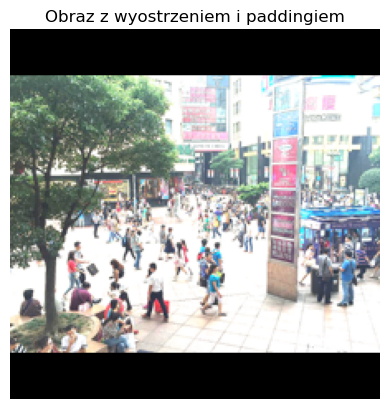

In [13]:
X_1, y_1 = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

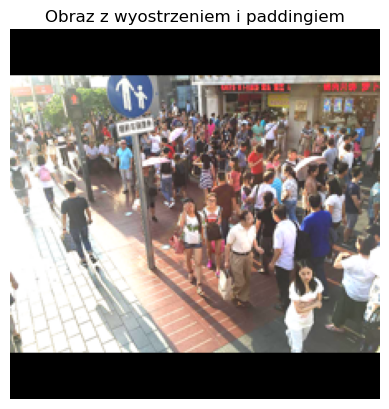

In [14]:
X_2, y_2 = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [15]:
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

In [18]:
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=20,
    validation_data=(X_test, y_test)
)

C:\Users\jakub\anaconda3\envs\cnn_e\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 7/36 ━━━━━━━━━━━━━━━━━━━━ 4:04 8s/step - loss: 26511.9238 - mae: 128.5831  


KeyboardInterrupt


KeyboardInterrupt



## Testing the model